In [1]:
import numpy as np
import matplotlib.pyplot as plt
import energyflow as ef
import energyflow.archs
from energyflow.archs import PFN
from matplotlib import gridspec
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Layer, concatenate
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
from tensorflow.keras.layers import BatchNormalization

plt.rc('font', size=20)

In [2]:
#These are the same datasets from the OmniFold paper https://arxiv.org/abs/1911.09107.  More detail at https://energyflow.network/docs/datasets/.
#Pythia and Herwig are two generators; one will be treated here as the "simulation" and one as "data".
datasets = {'Pythia26': ef.zjets_delphes.load('Pythia26', num_data=1000000),
            'Herwig': ef.zjets_delphes.load('Herwig', num_data=1000000)}

<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [3]:
w_true = datasets['Pythia26']['gen_widths'] #gen = particle level
w_reco = datasets['Pythia26']['sim_widths'] #sim = detector level
w_true_alt = datasets['Herwig']['gen_widths']
w_reco_alt = datasets['Herwig']['sim_widths']

In [4]:
initializer = tf.keras.initializers.RandomUniform(minval=-5., maxval=5.)
n = 1

class MyLayer(Layer):

    def __init__(self, myc, **kwargs):
        self.myinit = myc
        super(MyLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        self._lambda = self.add_weight(name='lambda', 
                                    shape=(n,),
                                    initializer=tf.keras.initializers.Constant(self.myinit), 
                                    trainable=True)
        
        super(MyLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, x):
        #return tf.exp(self._lambda1 * x + self._lambda0)
        return tf.exp(sum([self._lambda[i]* x**(i+1) for i in range(n)]))

In [5]:
def weighted_binary_crossentropy(y_true, y_pred):
    weights = tf.gather(y_true, [1], axis=1) # event weights
    y_true = tf.gather(y_true, [0], axis=1) # actual y_true for loss

    weights_1 = K.sum(y_true*weights)
    weights_0 = K.sum((1-y_true)*weights)

    # Clip the prediction value to prevent NaN's and Inf's
    epsilon = K.epsilon()
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    t_loss = -weights * ((y_true) * K.log(y_pred)/weights_1 +
                         (1 - y_true) * K.log(1 - y_pred)/weights_0)
    return K.mean(t_loss)

def weighted_binary_crossentropy_GAN(y_true, y_pred):
    weights = tf.gather(y_pred, [1], axis=1) # event weights
    y_pred = tf.gather(y_pred, [0], axis=1) # actual y_pred for loss

    weights_1 = K.sum(y_true*weights)
    weights_0 = K.sum((1-y_true)*weights)

    #tf.print("weights",weights_0,weights_1)

    # Clip the prediction value to prevent NaN's and Inf's
    epsilon = K.epsilon()
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    t_loss = weights * ((1 - y_true) * K.log(1 - y_pred)/weights_0)
    return K.mean(t_loss)

In [6]:
xvals_1 = np.concatenate([w_true_alt,w_true])
yvals_1 = np.concatenate([np.ones(len(w_true_alt)),np.zeros(len(w_true))])

X_train_1, X_test_1, Y_train_1, Y_test_1 = train_test_split(xvals_1, yvals_1)


N = 20
n = 1
errors_weighted = np.zeros((N, N))
errors_unweighted = np.zeros((N, N))

while n < N:
    print(f"{n = }")
    myc = 0.1
    mymodel_inputtest = Input(shape=(1,))
    mymodel_test = MyLayer(myc)(mymodel_inputtest)
    model_generator = Model(mymodel_inputtest, mymodel_test)

    inputs_disc = Input((1, ))
    hidden_layer_1_disc = Dense(50, activation='relu')(inputs_disc)
    hidden_layer_2_disc = Dense(50, activation='relu')(hidden_layer_1_disc)
    hidden_layer_3_disc = Dense(50, activation='relu')(hidden_layer_2_disc)
    outputs_disc = Dense(1, activation='sigmoid')(hidden_layer_3_disc)
    model_discrimantor = Model(inputs=inputs_disc, outputs=outputs_disc)
    
    model_discrimantor.compile(loss=weighted_binary_crossentropy, optimizer='adam')

    model_discrimantor.trainable = False
    mymodel_gan = Input(shape=(1,))
    gan_model = Model(inputs=mymodel_gan,outputs=concatenate([model_discrimantor(mymodel_gan),model_generator(mymodel_gan)]))

    gan_model.compile(loss=weighted_binary_crossentropy_GAN, optimizer='adam')
    n_epochs = 2
    n_batch = 128*10
    n_batches = len(X_train_1) // n_batch

    for i in range(n_epochs):
        #print("  ",np.sum(model_generator.predict(X_train_1,batch_size=1000)))
        for j in range(n_batches):
            X_batch = X_train_1[j*n_batch:(j+1)*n_batch]
            Y_batch = Y_train_1[j*n_batch:(j+1)*n_batch]
            W_batch = model_generator(X_batch)
            W_batch = np.array(W_batch).flatten()
            W_batch[Y_batch==1] = 1
            #W_batch[Y_batch==0] = 1

            Y_batch_2 = np.stack((Y_batch, W_batch), axis=1)

            model_discrimantor.train_on_batch(X_batch, Y_batch_2)

            gan_model.train_on_batch(X_batch[Y_batch==0],np.zeros(len(X_batch[Y_batch==0])))
            
        mylambda = np.array(model_generator.layers[-1].get_weights())
        print("on epoch=",i, mylambda)

    arr = np.array([mylambda[:, k]*w_true**(k+1) for k in range(n)])
    exponent = np.exp(np.sum(arr, axis=0))
    weights_1 = np.concatenate([np.ones(len(w_true_alt)),exponent*len(w_true_alt)/np.sum(exponent)])

    X_train_1, X_test_1, Y_train_1, Y_test_1, w_train_1, w_test_1 = train_test_split(xvals_1, 
                                                                                    yvals_1, weights_1)

    #data, simulation w/o weights, weighted simulation
    for i in range(n):
        print("Moment ", i+1)
        print(np.mean(X_test_1[Y_test_1==1]**(i+1)),np.mean(X_test_1[Y_test_1==0]**(i+1)),np.average(X_test_1[Y_test_1==0]**(i+1),weights=w_test_1[Y_test_1==0]))
    errors_weighted[:, n] = [(np.average(X_test_1[Y_test_1==0]**(i+1),weights=w_test_1[Y_test_1==0]) - np.mean(X_test_1[Y_test_1==1]**(i+1)))/np.average(X_test_1[Y_test_1==0]**(i+1),weights=w_test_1[Y_test_1==0]) for i in range(N)]
    errors_unweighted[:, n] = [(np.mean(X_test_1[Y_test_1==0]**(i+1)) - np.mean(X_test_1[Y_test_1==1]**(i+1)))/np.mean(X_test_1[Y_test_1==0]**(i+1)) for i in range(N)]
    n += 1
    print("\n\n\n")

n = 1
on epoch= 0 [[1.2852489]]
on epoch= 1 [[2.023513]]
Moment  1
0.1498924230074019 0.12285212839075273 0.14428179250348638




n = 2
on epoch= 0 [[1.1821086 1.0487127]]
on epoch= 1 [[1.7101277 1.1622984]]
Moment  1
0.1502293835284692 0.1228625622776709 0.14681083149170432
Moment  2
0.033906656916533655 0.024106645880669495 0.03450162112917496




n = 3
on epoch= 0 [[1.1586323  1.0011722  0.82392126]]
on epoch= 1 [[1.678406  1.0298454 0.3873968]]
Moment  1
0.1499066362013808 0.12316078745284414 0.14686984071438788
Moment  2
0.033776813025060366 0.024203130451374854 0.03450584458875354
Moment  3
0.009947419777480728 0.006615707310282109 0.01080650363394092




n = 4
on epoch= 0 [[1.1466273  0.99129677 0.8188364  0.6440243 ]]
on epoch= 1 [[ 1.6650835   1.0044161   0.3605462  -0.02408749]]
Moment  1
0.14995789356006392 0.12277345086119622 0.1460157796061345
Moment  2
0.03372210065746702 0.024075221042131775 0.03416028427043891
Moment  3
0.009897575148826282 0.006576448604792517 0.010675





n = 12
on epoch= 0 [[1.1632004  1.0060146  0.82474035 0.6376396  0.4602552  0.31380445
  0.21360123 0.15606001 0.12670685 0.11261019 0.10598465 0.102873  ]]
on epoch= 1 [[ 1.6999637   1.0310279   0.3535345  -0.04994786 -0.20994058 -0.21194912
  -0.13894406 -0.05601749  0.00716704  0.04741874  0.07089347  0.08401912]]
Moment  1
0.14963587648676674 0.12287171128860047 0.1465450173994452
Moment  2
0.03364723879182263 0.024104151725749017 0.034375487970863074
Moment  3
0.009885963720723479 0.0065865082866451916 0.010763348483383627
Moment  4
0.0034211188827956347 0.0021949423864001403 0.003950120721777367
Moment  5
0.0013133915368553491 0.000823908521512759 0.001591406924260827
Moment  6
0.0005410623320891245 0.0003340691039936872 0.0006816470863054836
Moment  7
0.0002345951178165048 0.00014302607036169456 0.00030519695802690817
Moment  8
0.00010578002794772956 6.380440850885836e-05 0.00014143743073154468
Moment  9
4.921440840954847e-05 2.9413452658827008e-05 6.742724490557358e-05
Mome

2.3170049191596265e-05 1.3690531425953152e-05 3.165771056190309e-05
Moment  11
1.1296489093458889e-05 6.588480743458999e-06 1.5633200598494668e-05
Moment  12
5.619012568016617e-06 3.2338204477571217e-06 7.859903703617642e-06
Moment  13
2.845769236202635e-06 1.6157128658002012e-06 4.01704659270209e-06
Moment  14
1.4651646804703582e-06 8.20507099769933e-07 2.084381341137863e-06
Moment  15
7.659195906823071e-07 4.230151936122938e-07 1.0969329288276173e-06
Moment  16
4.061147587791151e-07 2.2118664487753978e-07 5.849602199764567e-07
Moment  17
2.1822654146983027e-07 1.1719858481715949e-07 3.158376661907208e-07




n = 18
on epoch= 0 [[1.1695185  0.9973798  0.79682326 0.594863   0.41416487 0.27563623
  0.18772118 0.14063917 0.11812589 0.1079724  0.10349804 0.10153695
  0.100676   0.10029703 0.10012963 0.10005593 0.10002381 0.10000975]]
on epoch= 1 [[ 1.7078855e+00  1.0230709e+00  3.1994015e-01 -9.9928610e-02
  -2.5956509e-01 -2.5000212e-01 -1.6335966e-01 -7.0170671e-02
  -7.0160802e-04  4.3

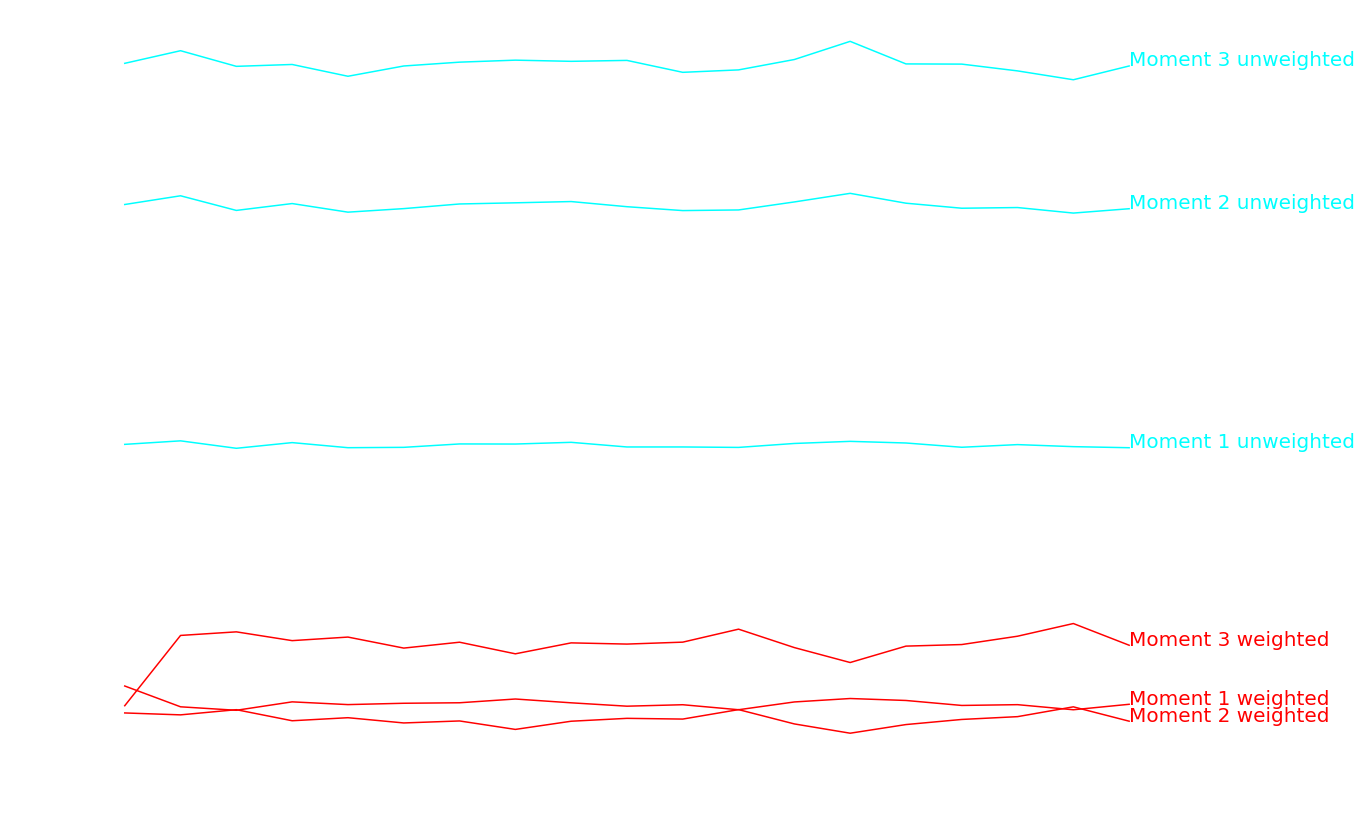

In [10]:
fig, ax = plt.subplots(figsize=(20, 14))
for i in range(3):
    plt.plot(range(1, N), np.abs(errors_weighted[i])[1:], color='r')
    plt.text(range(1, N)[-1], np.abs(errors_weighted[i])[-1], f'Moment {i+1} weighted', color='r')
    plt.plot(range(1, N), np.abs(errors_unweighted[i])[1:], label=f'Moment {i+1} unweighted', color='cyan')
    plt.text(range(1, N)[-1], np.abs(errors_unweighted[i])[-1], f'Moment {i+1} unweighted', color='cyan')
    
ax.xaxis.label.set_color('white')        #setting up X-axis label color to yellow
ax.yaxis.label.set_color('white')          #setting up Y-axis label color to blue

ax.tick_params(axis='x', colors='white')    #setting up X-axis tick color to red
ax.tick_params(axis='y', colors='white')  #setting up Y-axis tick color to black

ax.spines['left'].set_color('white')        # setting up Y-axis tick color to red
ax.spines['top'].set_color('white')
ax.spines['right'].set_color('white') 
ax.spines['bottom'].set_color('white') 
plt.xlabel("Number of moments learned")
plt.ylabel("Error")
#plt.title("Unfolding Errors")
ax.xaxis.set_ticks([0,5,10, 15, 20])
plt.savefig("One_level_unfolding.pdf", bbox_inches='tight', transparent=True)
plt.show()